# Importing Modules

In [4]:
!pip install pyspark
!pip install sqlalchemy
!pip install mysql.connector

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=2551d55e22ad507cecd6d65384b4886973e3da92d50e42e219958a9e82a255a8
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 89.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mysql.connector: filename=mysql_connector-2.2.9-cp310-cp310-linux_x86_64.whl size=247953 sha256=3c9efcb8eeb005b5efbdafc510c351a3b7684cb433bf281b7

In [5]:
import os
import pyspark
import pandas as pd
import mysql.connector
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from pyspark.sql import SparkSession

from pyspark.sql.functions import concat, lit


# Suppressing Unusal warnings
import warnings
warnings.simplefilter("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

path = r"/content/drive/MyDrive/Data Science Projects/Big Data Project"
os.chdir(path)

Mounted at /content/drive


# Putting Data to SQL

In [4]:
# Load the CSV files
file_paths = [
    "russian_troll_tweets/irahandle_tweets_1.csv",
    "russian_troll_tweets/irahandle_tweets_2.csv",
    "russian_troll_tweets/irahandle_tweets_3.csv",
    "russian_troll_tweets/irahandle_tweets_4.csv",
    "russian_troll_tweets/irahandle_tweets_5.csv",
    "russian_troll_tweets/irahandle_tweets_6.csv",
    "russian_troll_tweets/irahandle_tweets_7.csv",
    "russian_troll_tweets/irahandle_tweets_8.csv",
    "russian_troll_tweets/irahandle_tweets_9.csv"
]

# Read and concatenate files using pandas
dfs = [pd.read_csv(file, engine='python') for file in file_paths]
concatenated_df = pd.concat(dfs, ignore_index=True)

# Sorting and Saving data
concatenated_df["publish_date"] = pd.to_datetime(concatenated_df["publish_date"])
concatenated_df = concatenated_df.sort_values("publish_date")
concatenated_df.to_csv("combined_data.csv", index=False)

# MySQL database credentials
db_host = "localhost"
db_user = "root"
db_password = "talit123"
db_name = "russian_troll_tweets"

# Connect to MySQL database
db = mysql.connector.connect(
    host=db_host,
    user=db_user,
    password=db_password,
    database=db_name
)

# Create a cursor object to execute SQL queries
cursor = db.cursor()

# Define the database table name
table_name = "tweets"

# Define the SQLAlchemy engine
engine = create_engine(f"mysql+pymysql://{db_user}:{db_password}@{db_host}/{db_name}")

# Insert the concatenated_df table into the MySQL database
concatenated_df.to_sql(name=table_name, con=engine, if_exists='replace', index=False)

# Commit the changes and close the connection
db.commit()
db.close()

# Loading Data to Pyspark

In [5]:
# Load the CSV files
file_paths = [
    "russian_troll_tweets/irahandle_tweets_1.csv",
    "russian_troll_tweets/irahandle_tweets_2.csv",
    "russian_troll_tweets/irahandle_tweets_3.csv",
    "russian_troll_tweets/irahandle_tweets_4.csv",
    "russian_troll_tweets/irahandle_tweets_5.csv",
    "russian_troll_tweets/irahandle_tweets_6.csv",
    "russian_troll_tweets/irahandle_tweets_7.csv",
    "russian_troll_tweets/irahandle_tweets_8.csv",
    "russian_troll_tweets/irahandle_tweets_9.csv"
]

# Read and concatenate files using pandas
dfs = [pd.read_csv(file, engine='python') for file in file_paths]
concatenated_df = pd.concat(dfs, ignore_index=True)

# Sorting and Saving data
concatenated_df["publish_date"] = pd.to_datetime(concatenated_df["publish_date"])
concatenated_df = concatenated_df.sort_values("publish_date")
concatenated_df.to_csv("combined_data.csv", index=False)

In [6]:
# Create a SparkSession
spark = SparkSession.builder.appName("Russian Troll Tweets").getOrCreate()

# Read the concatenated file using PySpark
concatenated_spark_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load('combined_data.csv')

# Show the DataFrame
concatenated_spark_df.show()

+------------------+---------------+--------------------+--------------------+-------------+-------------------+-------------------+-------------------+---------+-------+---------+------------+-------------+-------+----------------+
|external_author_id|         author|             content|              region|     language|       publish_date|     harvested_date|          following|followers|updates|post_type|account_type|new_june_2018|retweet|account_category|
+------------------+---------------+--------------------+--------------------+-------------+-------------------+-------------------+-------------------+---------+-------+---------+------------+-------------+-------+----------------+
|      4.80763276E8|        IRIS0_O|Реклама в Faceboo...|       United States|      Russian|2012-02-02 00:35:00|2012-02-02T00:40:00|                  8|        0|      3|     null|     Russian|        False|  False|      NonEnglish|
|      4.80763276E8|        IRIS0_O|"""Локомотив"" и ...|       Unit

# Data Preprocessing

In [7]:
from pyspark.sql.functions import col

# Filter the DataFrame to extract tweets from 2015 to 2017
concatenated_spark_df = concatenated_spark_df.filter((col("publish_date") >= "2015-01-01") & (col("publish_date") <= "2017-12-31"))

# Show the filtered DataFrame
concatenated_spark_df.show()

+------------------+--------------+--------------------+-------------+--------+-------------------+-------------------+---------+---------+-------+---------+------------+-------------+-------+----------------+
|external_author_id|        author|             content|       region|language|       publish_date|     harvested_date|following|followers|updates|post_type|account_type|new_june_2018|retweet|account_category|
+------------------+--------------+--------------------+-------------+--------+-------------------+-------------------+---------+---------+-------+---------+------------+-------------+-------+----------------+
|     2.944944427E9|    TODAYMIAMI|Cuban Government ...|      Unknown| English|2015-01-01 01:53:00|2015-01-01T01:53:00|        0|        0|     26|     null|       local|        False|  False|        NewsFeed|
|     2.944944427E9|    TODAYMIAMI|Cuban Government ...|      Unknown| English|2015-01-01 02:37:00|2015-01-01T02:37:00|        0|        0|     27|     null|   

In [7]:
from pyspark.ml.feature import StopWordsRemover
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import re

# Function to clean the text
def clean_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove retweets
    text = re.sub(r'RT', '', text)
    
    # Lowercase the words
    text = text.lower()
    
    return text

In [8]:


# Define the UDF (User Defined Function)
clean_text_udf = udf(clean_text, StringType())

# Apply the cleaning transformations
cleaned_spark_df = concatenated_spark_df.withColumn("cleaned_content", clean_text_udf("content"))

# Show the cleaned DataFrame
cleaned_spark_df.show(truncate=False)

+------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------+-------------------+-------------------+---------+---------+-------+---------+------------+-------------+-------+----------------+------------------------------------------------------------------------------------------------------------------------------------------+
|external_author_id|author        |content                                                                                                                                   |region       |language|publish_date       |harvested_date     |following|followers|updates|post_type|account_type|new_june_2018|retweet|account_category|cleaned_content                                                                                                                           |
+------------------+--------------+-------------------------------

In [9]:
# Filter tweets with English language
cleaned_spark_df = cleaned_spark_df.filter(cleaned_spark_df.language == "English")

# Show the DataFrame with English tweets
cleaned_spark_df.show(truncate=False)

+------------------+--------------+------------------------------------------------------------------------------------------------------------------------------------------+-------------+--------+-------------------+-------------------+---------+---------+-------+---------+------------+-------------+-------+----------------+------------------------------------------------------------------------------------------------------------------------------------------+
|external_author_id|author        |content                                                                                                                                   |region       |language|publish_date       |harvested_date     |following|followers|updates|post_type|account_type|new_june_2018|retweet|account_category|cleaned_content                                                                                                                           |
+------------------+--------------+-------------------------------

In [10]:
# Drop duplicated records based on specific columns
cleaned_spark_df = cleaned_spark_df.dropDuplicates(subset=["content", "publish_date"])

In [11]:
import nltk
nltk.download('vader_lexicon')

from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType
from nltk.sentiment import SentimentIntensityAnalyzer

# Function to calculate polarity
def calculate_polarity(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    polarity = sentiment['compound']
    return polarity

# Define the UDF (User Defined Function)
calculate_polarity_udf = udf(calculate_polarity, DoubleType())

# Apply the polarity calculation
cleaned_spark_df = cleaned_spark_df.withColumn("polarity", calculate_polarity_udf("cleaned_content"))

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [12]:
from pyspark.sql.functions import to_date

# Extract date from publish_date column
cleaned_spark_df = cleaned_spark_df.withColumn("publish_date", to_date(cleaned_spark_df.publish_date))

# Data Analysis

In [8]:
df = pd.read_csv("combined_data.csv")

df = df[df.language == "English"]
df.drop_duplicates(["content"], inplace=True)

# Convert publish_date to datetime type
df['publish_date'] = pd.to_datetime(df['publish_date'])

# Filter tweets between 2016 and 2018
df = df[(df['publish_date'].dt.year >= 2016) & (df['publish_date'].dt.year <= 2018)]
df.publish_date = df.publish_date.apply(lambda x: pd.to_datetime(x).date())

# Cleaning Text
df.content = df.content.apply(clean_text)

from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

df["polarity"] = df.content.apply(get_polarity)

# Define the bin edges and labels for sentiment categories
bin_edges = [-float('inf'), -0.1, 0.1, float('inf')]
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Convert polarity to sentiment category
df['sentiment'] = pd.cut(df['polarity'], bins=bin_edges, labels=sentiment_labels)
df.head()

,external_author_id,author,content,region,language,publish_date,harvested_date,following,followers,updates,post_type,account_type,new_june_2018,retweet,account_category,polarity,sentiment
832995,3.085226e+09,MILWAUKEEVOICE,paper delivery worker alerts tosa family to ho...,United States,English,2016-01-01,2016-01-01T00:00:00,2516,1854,4851,NaN,local,False,False,NewsFeed,0.0,Neutral
832996,3.899482e+09,TODAYINSYRIA,’s role in essential,United Kingdom,English,2016-01-01,2016-01-01T00:01:00,5030,11205,1789,NaN,news,False,False,NewsFeed,0.0,Neutral
832997,2.601236e+09,TODAYPITTSBURGH,old-fashioned oakdale barber shop closes after...,United States,English,2016-01-01,2016-01-01T00:03:00,6673,14617,21466,NaN,local,False,False,NewsFeed,0.0,Neutral
832998,2.547142e+09,CHICAGODAILYNEW,divvy raises rates for annual bike-share memb...,United States,English,2016-01-01,2016-01-01T00:04:00,11397,14931,36156,NaN,local,False,False,NewsFeed,0.0,Neutral
832999,2.943515e+09,SCREAMYMONKEY,"police evacuate two munich train stations, cit...",United States,English,2016-01-01,2016-01-01T00:06:00,14331,13267,22376,NaN,news,False,False,NewsFeed,0.0,Neutral


WORLDNEWSPOLI      35082
AMELIEBALDWIN      31986
KANSASDAILYNEWS    27335
DAILYSANFRAN       26859
SCREAMYMONKEY      22914
COVFEFENATIONUS    21638
CHICAGODAILYNEW    20722
TODAYNYCITY        18478
ROOMOFRUMOR        16437
SPECIALAFFAIR      16271
Name: author, dtype: int64


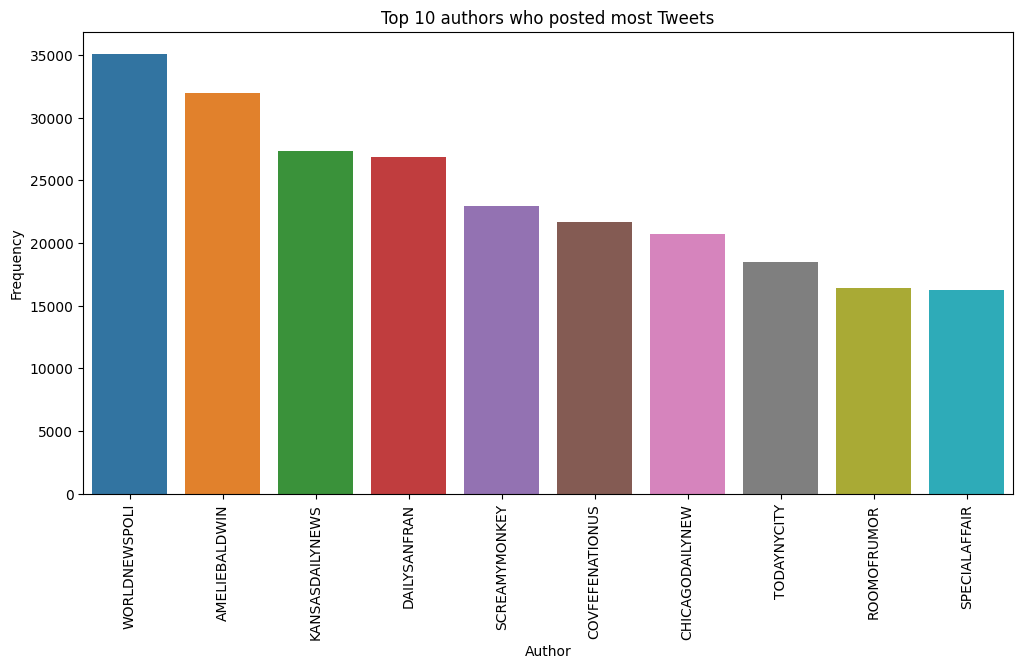

In [9]:
author = df.author.value_counts().head(10)
print(author)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=author.index, y=author.values)
plt.xlabel('Author')
plt.ylabel('Frequency')
plt.title('Top 10 authors who posted most Tweets')
plt.xticks(rotation=90)
plt.show()

WORLDNEWSPOLI      35082
AMELIEBALDWIN      31986
KANSASDAILYNEWS    27335
DAILYSANFRAN       26859
SCREAMYMONKEY      22914
COVFEFENATIONUS    21638
CHICAGODAILYNEW    20722
TODAYNYCITY        18478
ROOMOFRUMOR        16437
SPECIALAFFAIR      16271
Name: author, dtype: int64


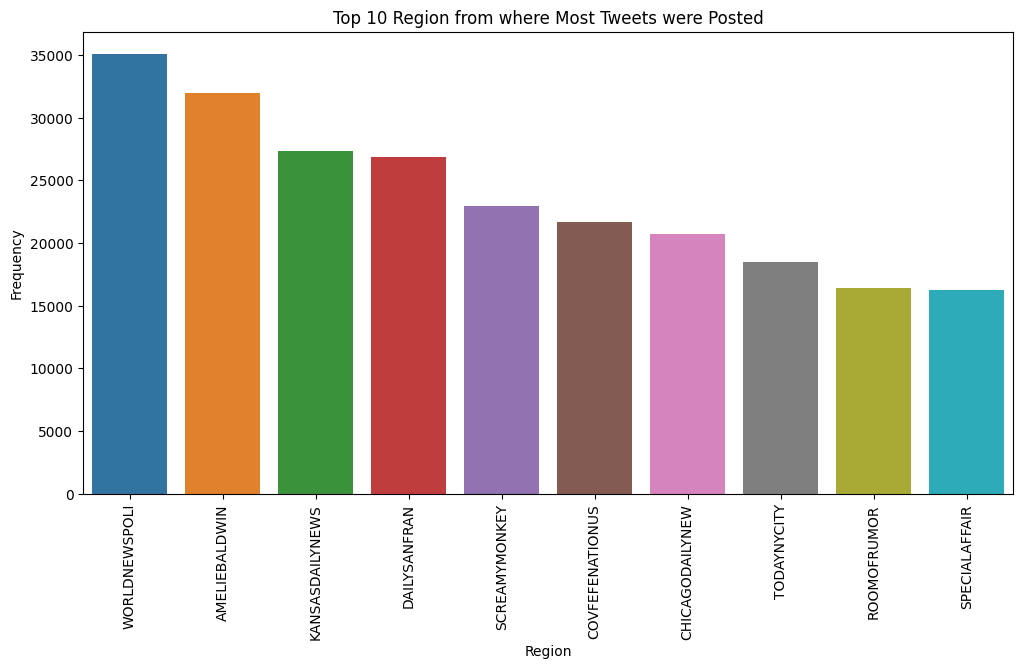

In [10]:
region = df.author.value_counts().head(10)
print(region)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=region.index, y=region.values)
plt.xlabel('Region')
plt.ylabel('Frequency')
plt.title('Top 10 Region from where Most Tweets were Posted')
plt.xticks(rotation=90)
plt.show()

RightTroll      522939
NewsFeed        456543
LeftTroll       300240
HashtagGamer     84631
NonEnglish       15495
Unknown           1798
Commercial        1319
Fearmonger          43
Name: account_category, dtype: int64


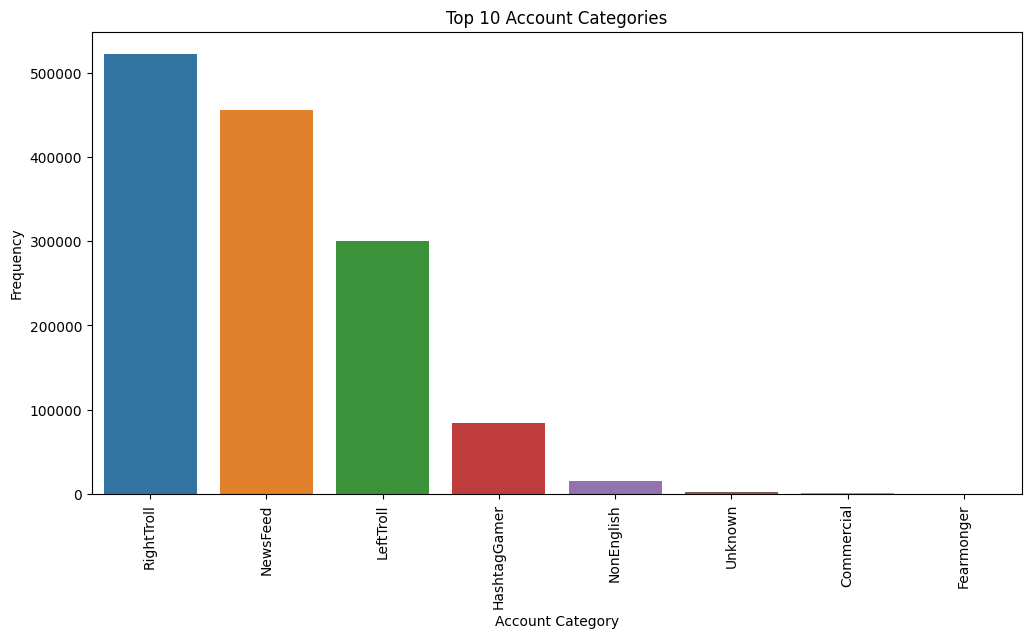

In [11]:
account_category = df.account_category.value_counts().head(10)
print(account_category)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=account_category.index, y=account_category.values)
plt.xlabel('Account Category')
plt.ylabel('Frequency')
plt.title('Top 10 Account Categories')
plt.xticks(rotation=90)
plt.show()

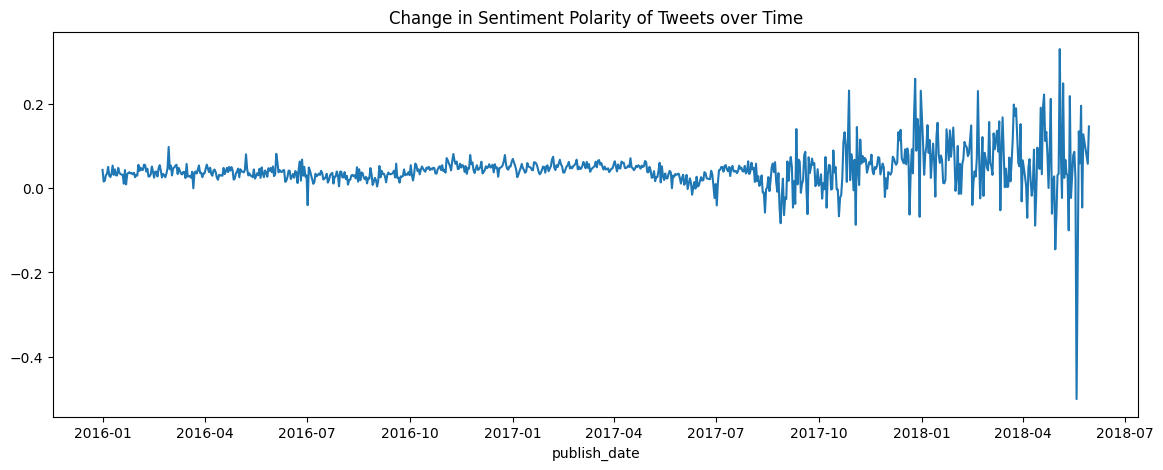

In [12]:
df.groupby('publish_date').mean()["polarity"].plot(kind="line", figsize=(14, 5))
plt.title("Change in Sentiment Polarity of Tweets over Time")
plt.show()

In [13]:
df_new = df.groupby('publish_date').mean()[["polarity"]]

In [14]:
df_new

,polarity
publish_date,
2016-01-01,0.042954
2016-01-02,0.015451
2016-01-03,0.016967
2016-01-04,0.030701
2016-01-05,0.033920
...,...
2018-05-23,0.194773
2018-05-24,-0.046192
2018-05-25,0.127273


# Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood op

Best parameters for 1-Week model: Order = (1, 0, 2), AIC = -595.9894199234909
Predicted polarity for 1-Week model: 0.031447 (Neutral)

Best parameters for 1-Month model: Order = (0, 0, 2), AIC = -158.67380703994854
Predicted polarity for 1-Month model: 0.061970 (Positive)

Best parameters for 3-Month model: Order = (2, 0, 1), AIC = -56.1423468323527
Predicted polarity for 3-Month model: 0.014237 (Neutral)



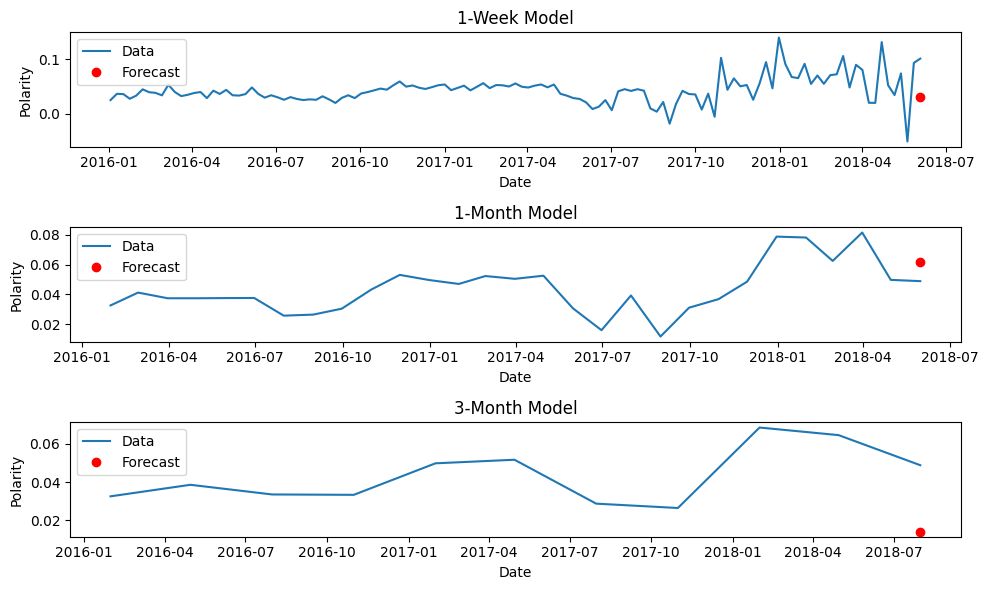

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from itertools import product

# Set the frequency of the time series data
df_new.index = pd.to_datetime(df_new.index)
df_new = df_new.asfreq('D')

# Define function for ARIMA model training and selection of best parameters
def train_arima_model(data, order_range):
    best_aic = float("inf")
    best_order = None

    for order in order_range:
        try:
            model = ARIMA(data, order=order)
            model_fit = model.fit()
            aic = model_fit.aic

            if aic < best_aic:
                best_aic = aic
                best_order = order
        except:
            continue

    return best_order, best_aic

# Set the parameter ranges for tuning
p_range = range(0, 3)
q_range = range(0, 3)
d_range = range(0, 2)
order_range = list(product(p_range, d_range, q_range))

# Prepare data for each model
data_1w = df_new['polarity'].resample('W').mean()
data_1m = df_new['polarity'].resample('M').mean()
data_3m = df_new['polarity'].resample('3M').mean()

# Train and forecast for each model
models = []
forecasts = []
best_orders = []
best_aics = []

for data in [data_1w, data_1m, data_3m]:
    # Split data into train and test sets
    train_data = data[:-1]  # Use last period for testing
    test_data = data[-1:]

    # Train model and select best parameters
    best_order, best_aic = train_arima_model(train_data, order_range)
    best_orders.append(best_order)
    best_aics.append(best_aic)

    # Train model with best parameters
    model = ARIMA(train_data, order=best_order)
    model_fit = model.fit()
    models.append(model_fit)

    # Forecast for test data
    forecast = model_fit.forecast(steps=len(test_data))
    forecasts.append(forecast)

# Define sentiment ranges
sentiment_ranges = {
    'Positive': (0.05, 1),
    'Neutral': (-0.05, 0.05),
    'Negative': (-1, -0.05)
}

# Print best parameters, AIC values, and predicted sentiment
for i, data in enumerate(['1-Week', '1-Month', '3-Month']):
    print(f"Best parameters for {data} model: Order = {best_orders[i]}, AIC = {best_aics[i]}")

    # Map forecasted polarity to sentiment
    polarity = forecasts[i][0]
    predicted_sentiment = None
    for sentiment, (lower, upper) in sentiment_ranges.items():
        if lower <= polarity <= upper:
            predicted_sentiment = sentiment
            break

    print(f"Predicted polarity for {data} model: {polarity:.6f} ({predicted_sentiment})")
    print()



# Plotting
plt.figure(figsize=(10, 6))

# Plot 1-week model
plt.subplot(3, 1, 1)
plt.plot(data_1w.index, data_1w.values, label='Data')
plt.plot(data_1w.index[-1], forecasts[0], 'ro', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('1-Week Model')
plt.legend()

# Plot 1-month model
plt.subplot(3, 1, 2)
plt.plot(data_1m.index, data_1m.values, label='Data')
plt.plot(data_1m.index[-1], forecasts[1], 'ro', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('1-Month Model')
plt.legend()

# Plot 3-month model
plt.subplot(3, 1, 3)
plt.plot(data_3m.index, data_3m.values, label='Data')
plt.plot(data_3m.index[-1], forecasts[2], 'ro', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Polarity')
plt.title('3-Month Model')
plt.legend()

plt.tight_layout()
plt.show()